In [39]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta, date
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
df = pd.read_csv("./result.csv")

In [41]:
df.info

<bound method DataFrame.info of                      Created_time  \
0      2021-12-19 17:24:20.384430   
1      2021-12-19 17:24:23.339806   
2      2021-12-19 17:24:27.288977   
3      2021-12-19 17:24:30.072343   
4      2021-12-19 17:24:35.264820   
...                           ...   
11397  2021-12-24 16:06:43.400516   
11398  2021-12-24 16:06:45.029451   
11399  2021-12-24 16:07:21.214034   
11400  2021-12-24 16:07:22.686972   
11401  2021-12-24 16:07:24.578273   

                                                     URL  \
0      https://www.olx.ua/d/obyavlenie/iphone-11-pro-...   
1      https://www.olx.ua/d/obyavlenie/apple-iphone-1...   
2      https://www.olx.ua/d/obyavlenie/zahisne-sklo-i...   
3      https://www.olx.ua/d/obyavlenie/zahisne-sklo-t...   
4      https://www.olx.ua/d/obyavlenie/topovoe-steklo...   
...                                                  ...   
11397  https://www.olx.ua/d/obyavlenie/iphone-7-rose-...   
11398  https://www.olx.ua/d/obyavlenie/zahi

In [42]:
print(df.shape)
print(df[(df['Views'] != 'нет просмотров') & (df['Views'].notnull())].shape)

(11402, 14)
(6220, 14)


In [43]:
# filter data
df = df[(df['Views'] != 'нет просмотров') & (df['Views'].notnull()) & (df['URL'] != 'URL')]

In [44]:
TRUE_FALSE_MAP = {
    "True": 1,
    "False": 0
}

df = df.assign(views = df['Views'].apply(int))
df = df.assign(olxdelivery = df['OlxDelivery'].map(TRUE_FALSE_MAP))
df = df.assign(is_promoted = df['Is_promoted'].map(TRUE_FALSE_MAP))

In [45]:
def clean_url(url):
    res = re.search(r'(.*.html).*', url)
    if res:
        return res.group(1)
    else:
        print(url)
        return None
   
df = df.assign(cleaned_URL = df['URL'].apply(clean_url))

In [46]:
df.drop_duplicates('cleaned_URL').shape
df = df.drop_duplicates('cleaned_URL')

In [47]:
# add description len and number of lines in the description
df = df.assign(description_size = df['Description'].apply(lambda x: len(x)))
df = df.assign(description_lines = df['Description'].apply(lambda x: len(x.splitlines())))
df = df.assign(name_size = df['Name'].apply(lambda x: len(x)))

In [48]:
# fix Author_from_data

MONTHS = {
    'январь': 1,
    'февраль': 2,
    'март': 3,
    'апрель': 4,
    'май': 5,
    'июнь': 6,
    'июль': 7,
    'август': 8,
    'сентябрь': 9,
    'октябрь': 10,
    'ноябрь': 11,
    'декабрь': 12,
}

def clean_author_from_data(auth_date):
    split = auth_date.split()
    month = MONTHS[split[0]]
    year = split[1]
    return date(year=int(year), month=int(month), day=1)

df = df.assign(Author_from_data_cleaned = df["Author_from_data"].apply(clean_author_from_data))

In [49]:
df['Author_from_data_cleaned']

0        2012-03-01
1        2017-06-01
2        2016-12-01
3        2015-03-01
4        2017-10-01
            ...    
11372    2014-08-01
11380    2021-12-01
11381    2018-12-01
11388    2015-12-01
11389    2012-09-01
Name: Author_from_data_cleaned, Length: 4450, dtype: object

In [50]:
def get_city(address):
    split = address.split(',')
    city = split[0].strip()
    return city
df = df.assign(city = df["Address"].apply(get_city))
df['city']

0           Киев
1           Киев
2          Львов
3          Львов
4           Киев
          ...   
11372    Харьков
11380    Харьков
11381       Луцк
11388    Полтава
11389       Киев
Name: city, Length: 4450, dtype: object

In [51]:
df = df.assign(
    days_on_olx = (pd.to_datetime(df['Created_time']) - pd.to_datetime(df['Date'])).dt.total_seconds() / 60 / 60 / 24
)

In [52]:
df = df.assign(
    auth_days_on_olx = 
    (pd.to_datetime(df['Created_time']) - pd.to_datetime(df['Author_from_data_cleaned'])).dt.days
       )

In [53]:
df.groupby(['Auth_rating']).count()

,Created_time,URL,Name,Category,Price,Address,Date,OlxDelivery,Is_promoted,Author_from_data,...,olxdelivery,is_promoted,cleaned_URL,description_size,description_lines,name_size,Author_from_data_cleaned,city,days_on_olx,auth_days_on_olx
Auth_rating,,,,,,,,,,,,,,,,,,,,,
Неудовлетворительно,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
Отлично,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,...,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
Удовлетворительно,319,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
Хорошо,994,994,994,994,994,994,994,994,994,994,...,994,994,994,994,994,994,994,994,994,994
нет ни одного отзыва,1840,1840,1840,1840,1840,1840,1840,1840,1840,1840,...,1840,1840,1840,1840,1840,1840,1840,1840,1840,1840


In [54]:
RATING_MAP = {
    'Отлично': 5,
    'Хорошо': 4,
    'Удовлетворительно': 3,
    'нет ни одного отзыва': 2,
    'Неудовлетворительно': 1,
}

In [55]:
df = df.assign(
    auth_rating_int = df['Auth_rating'].apply(lambda x: RATING_MAP[x])
       )

In [56]:
df[['auth_rating_int', 'Auth_rating']]

,auth_rating_int,Auth_rating
0,5,Отлично
1,5,Отлично
2,2,нет ни одного отзыва
3,2,нет ни одного отзыва
4,2,нет ни одного отзыва
...,...,...
11372,2,нет ни одного отзыва
11380,2,нет ни одного отзыва
11381,3,Удовлетворительно
11388,5,Отлично


In [57]:
df = df.assign(category_cat = df['Category'].astype('category').cat.codes)

In [58]:
df = df.assign(city_cat = df['city'].astype('category').cat.codes)

<AxesSubplot:>

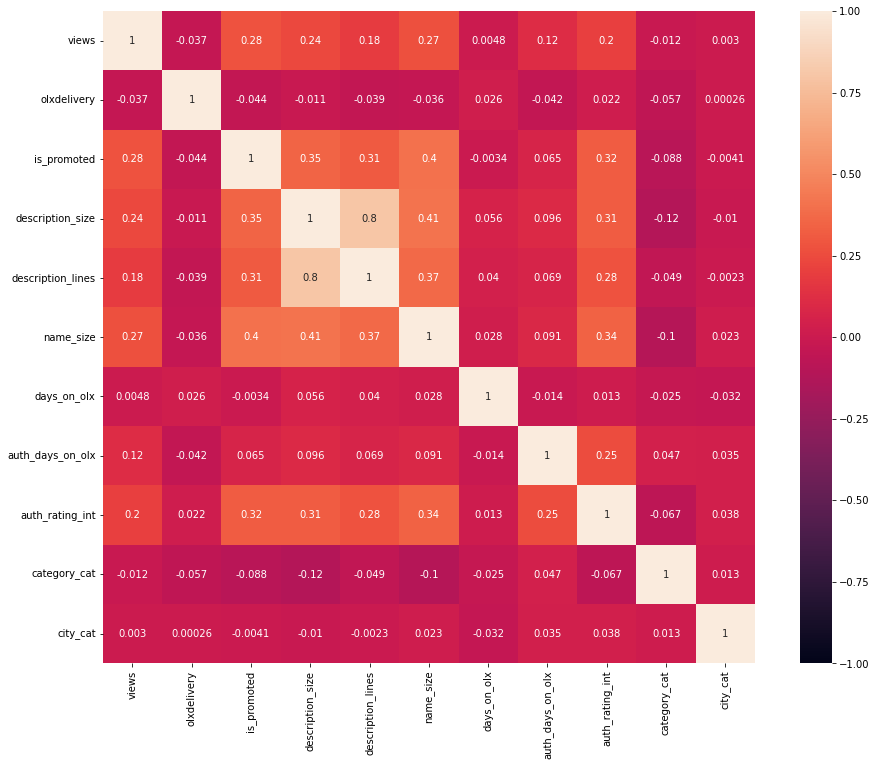

In [59]:
corr_matrix = df.corr()
plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, vmin = -1, vmax = 1, annot = True, square=True)

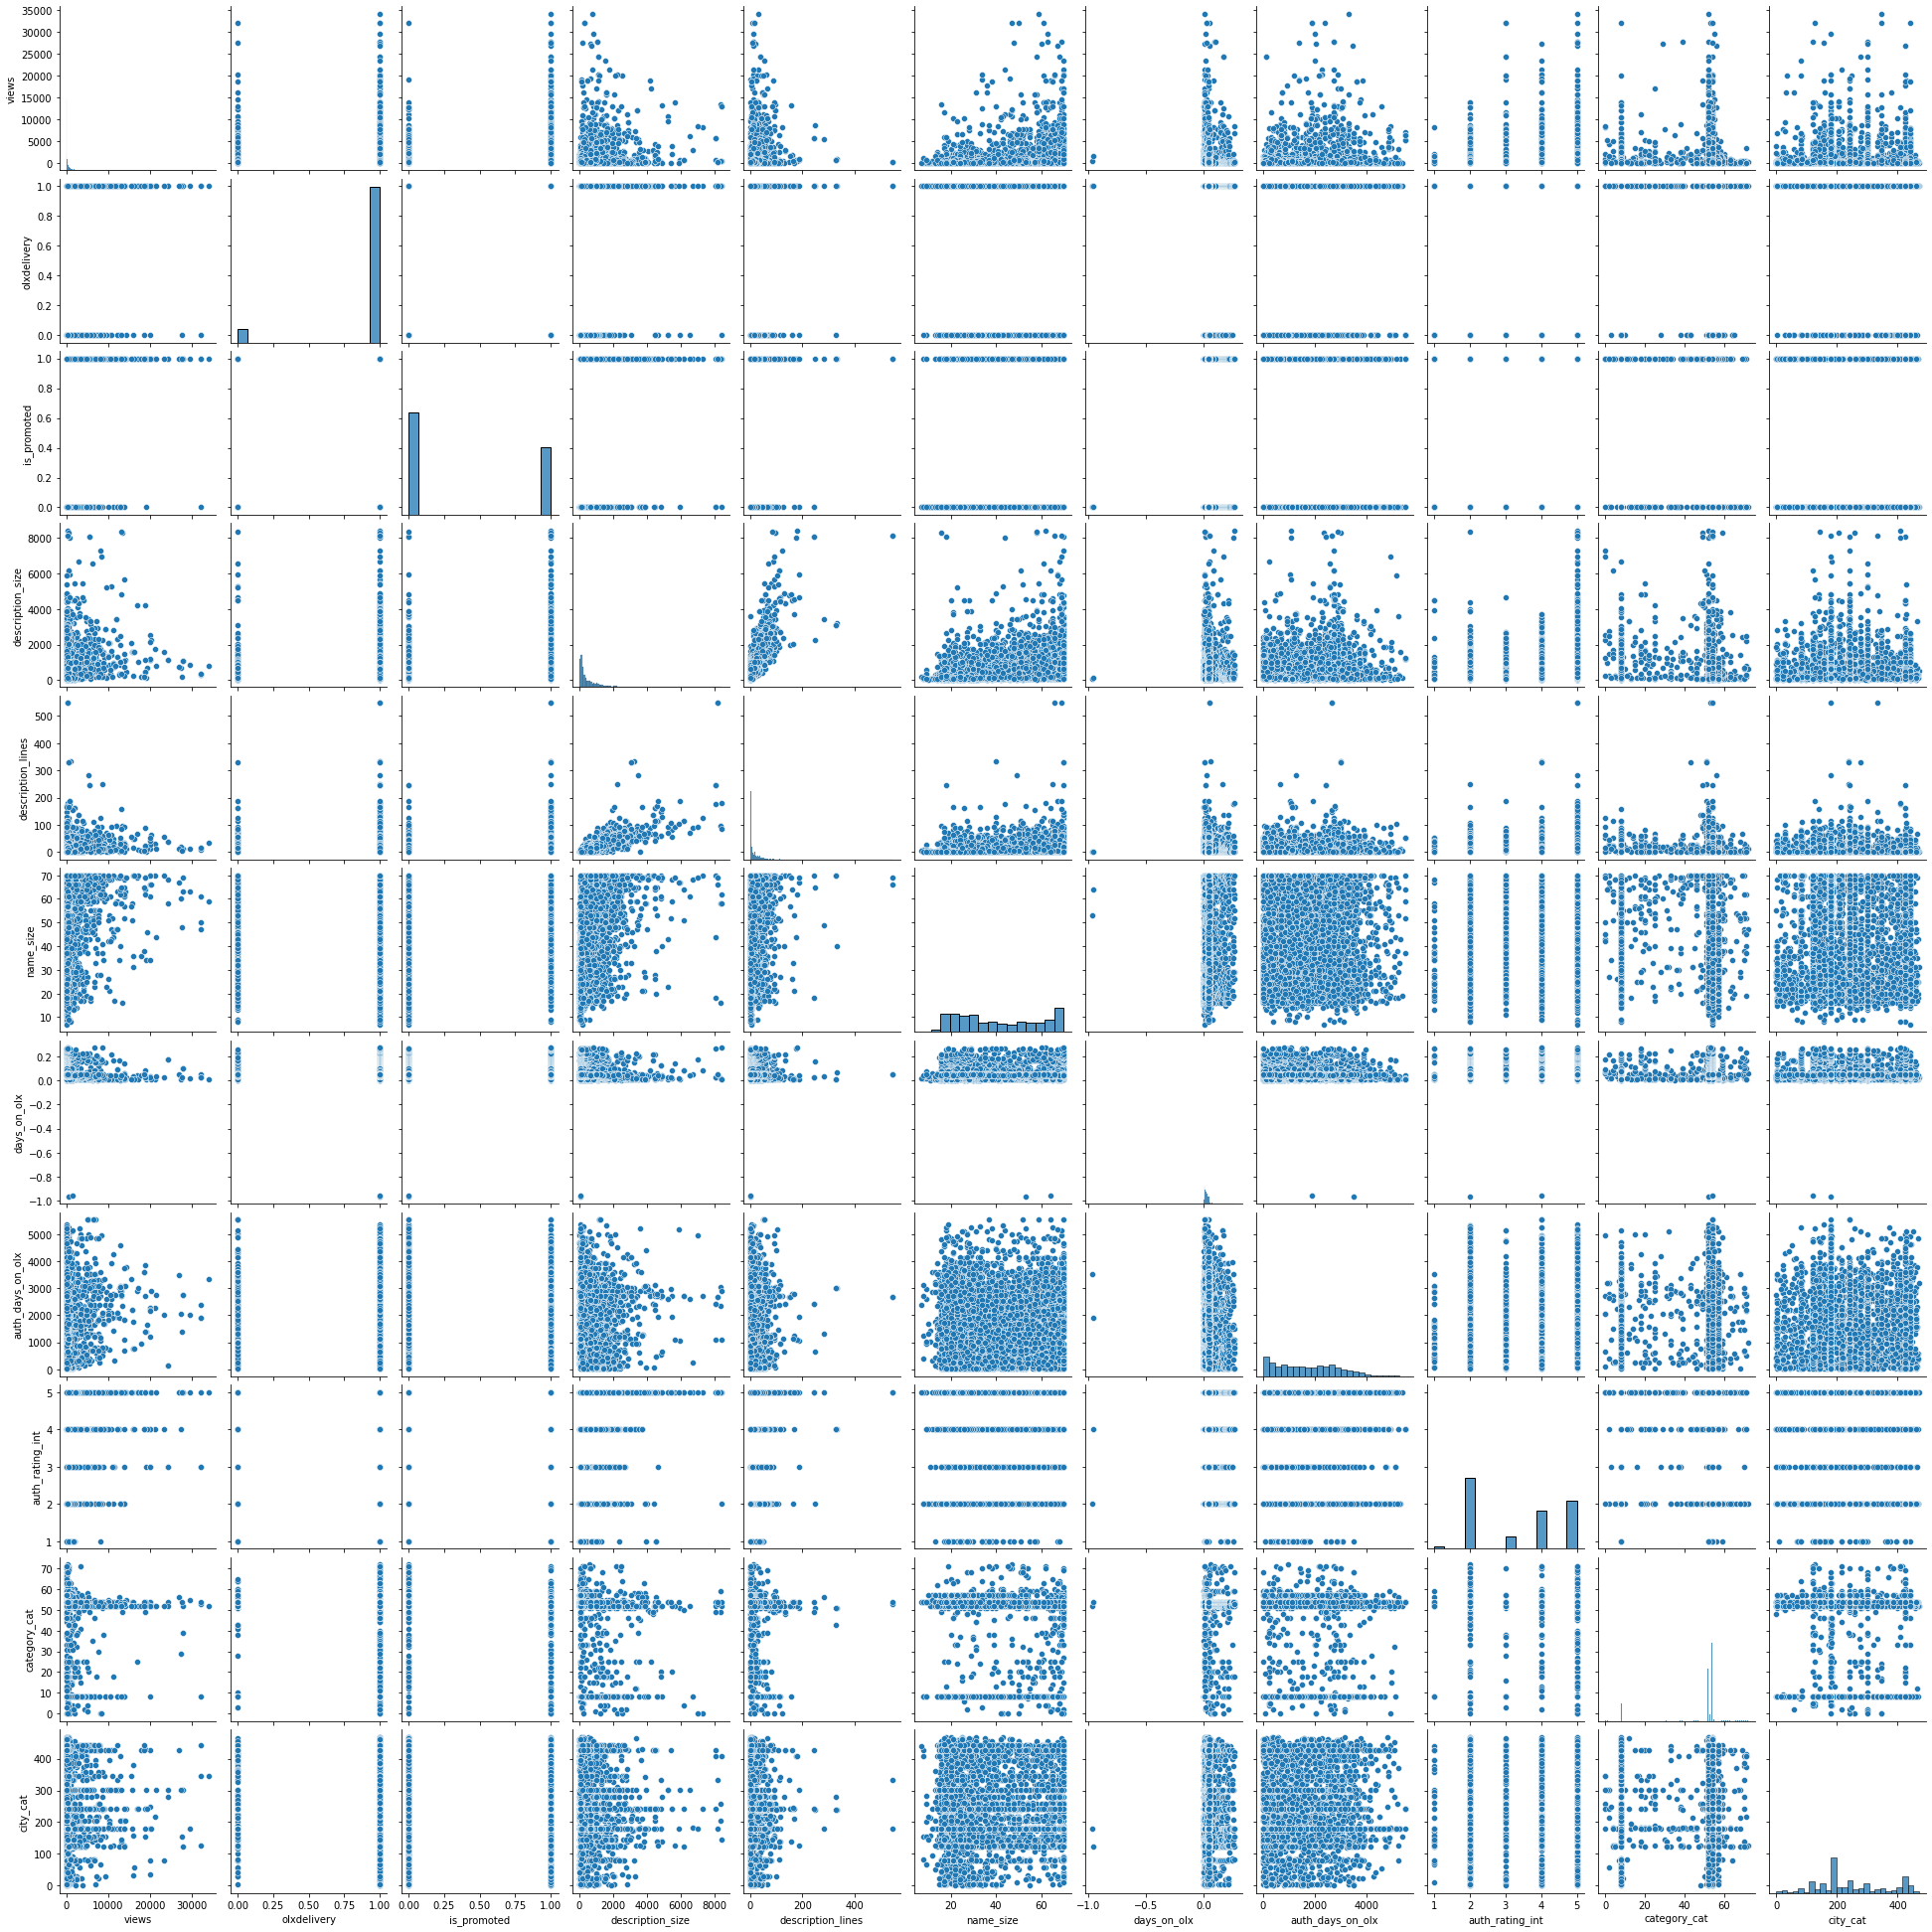

In [60]:
sns.pairplot(df)


In [61]:
df.groupby(['Category']).count()

,Created_time,URL,Name,Price,Address,Date,OlxDelivery,Is_promoted,Author_from_data,Views,...,description_size,description_lines,name_size,Author_from_data_cleaned,city,days_on_olx,auth_days_on_olx,auth_rating_int,category_cat,city_cat
Category,,,,,,,,,,,,,,,,,,,,,
Автозапчасти и аксессуары » GPS-навигаторы / авторегистраторы,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Автозапчасти и аксессуары » Автозвук,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Автозапчасти и аксессуары » Аксессуары для авто,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Аксессуары » Бижутерия,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Аксессуары » Другие аксессуары,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Фото / видео » Экшн-камеры,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
"Хобби, отдых и спорт » Другое",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Электроника » Аксессуары и комплектующие,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8


In [89]:
df = df.assign(
    is_price = df['Price'].apply(lambda x: 1 if x != 'Не указано' and x != 'Oбмен' else 0)
       )
df = df.assign(
    is_swap = df['Price'].apply(lambda x: 1 if x == 'Обмен' else 0)
       )
df = df.assign(
    price = df['Price'].apply(lambda x: float(x) if x != 'Не указано' and x != 'Обмен' else -1)
       )

In [93]:
df.groupby(['Photos_number']).count()

,Created_time,URL,Name,Category,Price,Address,Date,OlxDelivery,Is_promoted,Author_from_data,...,Author_from_data_cleaned,city,days_on_olx,auth_days_on_olx,auth_rating_int,category_cat,city_cat,is_price,price,is_swap
Photos_number,,,,,,,,,,,,,,,,,,,,,
1,319,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
2,494,494,494,494,494,494,494,494,494,494,...,494,494,494,494,494,494,494,494,494,494
3,569,569,569,569,569,569,569,569,569,569,...,569,569,569,569,569,569,569,569,569,569
4,532,532,532,532,532,532,532,532,532,532,...,532,532,532,532,532,532,532,532,532,532
5,507,507,507,507,507,507,507,507,507,507,...,507,507,507,507,507,507,507,507,507,507
6,544,544,544,544,544,544,544,544,544,544,...,544,544,544,544,544,544,544,544,544,544
7,461,461,461,461,461,461,461,461,461,461,...,461,461,461,461,461,461,461,461,461,461
8,996,996,996,996,996,996,996,996,996,996,...,996,996,996,996,996,996,996,996,996,996


In [92]:
final_df = df[
    ['city_cat',
     'category_cat',
     'auth_rating_int',
     'auth_days_on_olx',
     'days_on_olx',
     'name_size',
     'description_size',
     'description_lines',
     'is_promoted',
     'olxdelivery',
     'is_price',
     'is_swap',
     'price',
     'Photos_number',
     'Views'
     ]
]
final_df['price'] = final_df['price'].astype(float)
final_df['photos_number'] = final_df['Photos_number'].astype(int)
final_df['views'] = final_df['Views'].astype(int)

final_df.info()

/tmp/ipykernel_26821/70615324.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['price'] = final_df['price'].astype(float)


ValueError: cannot convert float NaN to integer

<AxesSubplot:>

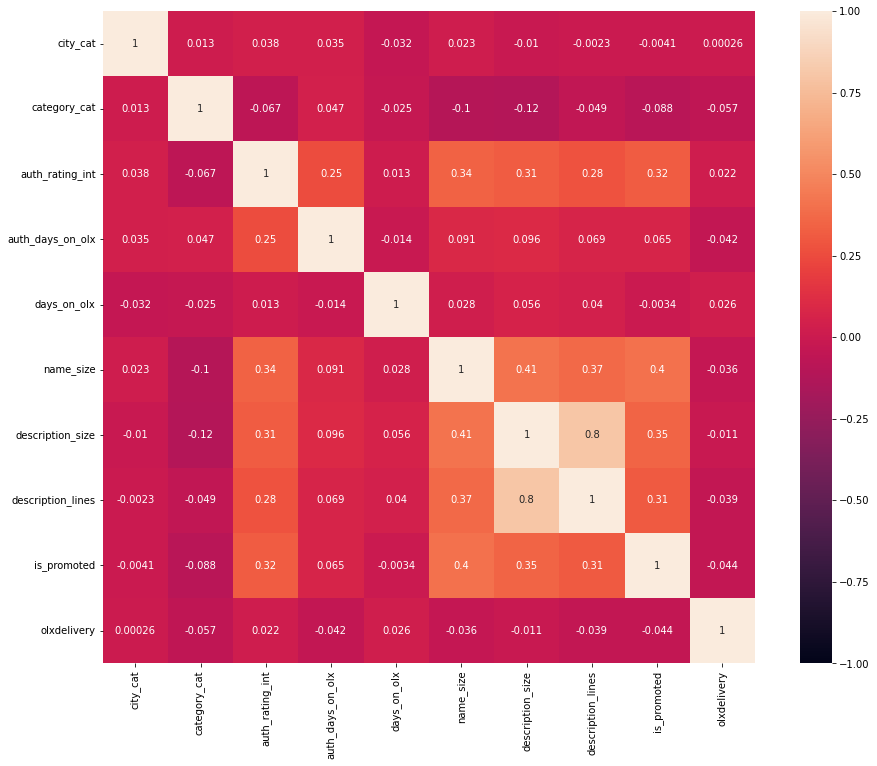

In [70]:
corr_matrix = final_df.corr()
plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, vmin = -1, vmax = 1, annot = True, square=True)

In [63]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25)

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 9709 to 2065
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Created_time              3337 non-null   object 
 1   URL                       3337 non-null   object 
 2   Name                      3337 non-null   object 
 3   Category                  3337 non-null   object 
 4   Price                     3337 non-null   object 
 5   Address                   3337 non-null   object 
 6   Date                      3337 non-null   object 
 7   OlxDelivery               3337 non-null   object 
 8   Is_promoted               3337 non-null   object 
 9   Author_from_data          3337 non-null   object 
 10  Views                     3337 non-null   object 
 11  Auth_rating               3337 non-null   object 
 12  Photos_number             3319 non-null   object 
 13  Description               3337 non-null   object 
 14  olxde

In [65]:
polynomial_model = make_pipeline(PolynomialFeatures(2),LinearRegression())    # polynolial regression


In [66]:
ytrain = train.views.values
ytest = test.views.values
train.drop('views', axis = 1, inplace = True)
test.drop('views', axis = 1, inplace = True)
polynomial_model.fit(train, ytrain)

ValueError: could not convert string to float: '2021-12-23 21:29:05.991859'

In [ ]:
preds = polynomial_model.predict(ytest)

In [ ]:
def rmsle(models, train, ytrain):
    rmse = 0
    for model in models:
        rmse += np.sqrt(-cross_val_score(model, train.values, ytrain, scoring="neg_mean_squared_error"))
    return np.mean(rmse / 2)

In [ ]:
rmse = rmsle([polynomial_model, ridge_model], train, ytrain)
total_price_sum = np.sum(ytrain)
print(rmse)

In [ ]:
dy_preds = (preds - ytest)
print("З викидами:", dy_preds.size)
dy_preds = dy_preds[abs(dy_preds) < 300000]
print("Без викидів:", dy_preds.size)
plt.hist(dy_preds, width=10000)
plt.show()